In [4]:
# Created on 22/10/2024 by Lewis Dickson  

#================================================================
# User Settings
#================================================================

# %%
h_lim = 168 #hours forecasting window
input_folder =r'./input_data/'
api_key = 'nixak-2LCbrvDu8uh6uONR7nnoU8L8i0B0ZR2UOpdNfiBnZs4S5vdFe73JXyDGz7r15mABHL5H7Xvmva2oCbXd' # your api 

# --- Analysis Options --- # 
fine_tune = True 
set_finetune_steps = 500


#================================================================
# Imports
#================================================================

import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate
import matplotlib.pyplot as plt

#================================================================
# Main -Forecast
#================================================================

# Launch API client
nixtla_client = NixtlaClient(
    api_key = api_key
)

# Validate API Key
if nixtla_client.validate_api_key():
    print('API Key Valid')
else:
    raise ValueError("API Key is not Valuid")

# Extract GT training data 
df = pd.read_csv('Data/1 - Savanna Preserve/1_y_train.csv')



API Key Valid


In [5]:
df

,Unnamed: 0,location_id,date,temperature_2m,relative_humidity_2m
0,0,1,2023-01-01 00:00:00+00:00,17.296999,69.0
1,1,1,2023-01-01 01:00:00+00:00,17.197000,67.0
2,2,1,2023-01-01 02:00:00+00:00,16.796999,65.0
3,3,1,2023-01-01 03:00:00+00:00,16.097000,66.0
4,4,1,2023-01-01 04:00:00+00:00,15.646999,70.0
...,...,...,...,...,...
15163,15163,1,2024-09-23 19:00:00+00:00,20.147000,53.0
15164,15164,1,2024-09-23 20:00:00+00:00,19.497000,54.0
15165,15165,1,2024-09-23 21:00:00+00:00,18.997000,56.0
15166,15166,1,2024-09-23 22:00:00+00:00,17.747000,63.0


In [6]:
from sklearn.metrics import mean_squared_error

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Unnamed: 0', 'location_id', 'relative_humidity_2m']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Unnamed: 0', 'location_id', 'temperature_2m']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


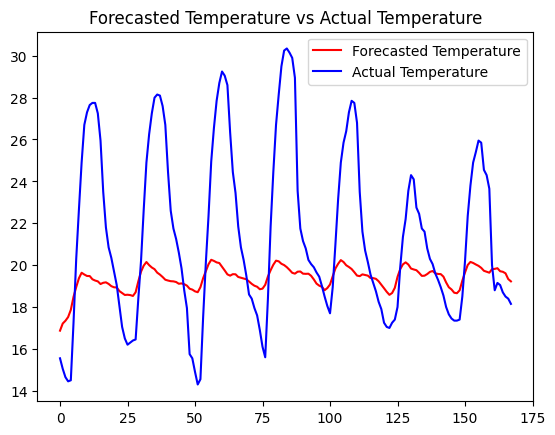

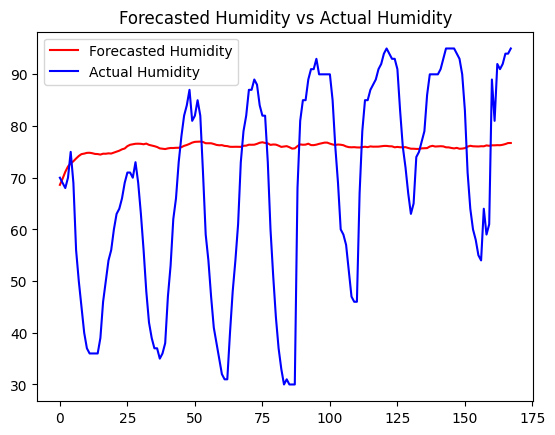

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Unnamed: 0', 'location_id', 'relative_humidity_2m']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


not Finetuned 18.972740579207215
not finetuned 460.8977578740429


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: The read operation timed out


In [16]:
# Temperature inference
timegpt_fcst_df_temperature = nixtla_client.forecast(df=df, h=168, freq='h', time_col='date', target_col='temperature_2m', model='timegpt-1-long-horizon')
timegpt_fcst_df_temperature["date"] = pd.to_datetime(timegpt_fcst_df_temperature["date"], utc=True)
# Humidity inference 
timegpt_fcst_df_humidity = nixtla_client.forecast(df=df, h=168, freq='h', time_col='date', target_col='relative_humidity_2m', model='timegpt-1-long-horizon')
timegpt_fcst_df_humidity["date"] = pd.to_datetime(timegpt_fcst_df_humidity["date"], utc=True)

# Load the test data 
df_test = pd.read_csv('Data/1 - Savanna Preserve/1_y_test.csv')

# Convert to datetime format (standard output from timeGPT)
df_test['date'] = pd.to_datetime(df_test['date'], utc=True)



# Combine X and y for easier analysis, non-matching dates are dropped
dF_valid = pd.merge(df_test, timegpt_fcst_df_temperature, on=['date'], how='inner')
dF_valid = pd.merge(dF_valid, timegpt_fcst_df_humidity, on=['date'], how='inner')

plt.plot(dF_valid['TimeGPT_x'], 'r', label ='Forecasted Temperature')
plt.plot(dF_valid['temperature_2m'], 'b', label ='Actual Temperature')
plt.legend()
plt.title('Forecasted Temperature vs Actual Temperature')
plt.show()

plt.plot(dF_valid['TimeGPT_y'], 'r', label ='Forecasted Humidity')
plt.plot(dF_valid['relative_humidity_2m'], 'b', label ='Actual Humidity')
plt.legend()
plt.title('Forecasted Humidity vs Actual Humidity')
plt.show()

print("not Finetuned", mean_squared_error(dF_valid['temperature_2m'], dF_valid['TimeGPT_x']))
print("not finetuned", mean_squared_error(dF_valid['relative_humidity_2m'], dF_valid['TimeGPT_y']))


if False: # plot of raw difference for each day
    dF_valid['Diff'] = dF_valid['temperature_2m'] - dF_valid['TimeGPT_x']
    plt.plot(dF_valid['Diff'])
    plt.show

#================================================================
# Main -Fine tuning
#================================================================

if fine_tune:
    # Perfrom fine tuning  
    """
    control the number of steps with finetune_steps
    Note: may need different values for the temp vs humidity
    """

    timegpt_fcst_finetune_df_temperature = nixtla_client.forecast(
        df=df, h=h_lim, finetune_steps=set_finetune_steps,
        time_col='date', target_col='temperature_2m',
        model='timegpt-1-long-horizon'
    )

    timegpt_fcst_finetune_df_humidity = nixtla_client.forecast(
        df=df, h=h_lim, finetune_steps=set_finetune_steps,
        time_col='date', target_col='relative_humidity_2m',
        model='timegpt-1-long-horizon'
    )

    timegpt_fcst_finetune_df_temperature["date"] = pd.to_datetime(timegpt_fcst_finetune_df_temperature["date"], utc=True)
    
    timegpt_fcst_finetune_df_humidity["date"] = pd.to_datetime(timegpt_fcst_finetune_df_humidity["date"], utc=True)
    
    
    # Load the test data 
    df_test = pd.read_csv('Data/1 - Savanna Preserve/1_y_test.csv')


    # Convert to datetime format
    df_test['date'] = pd.to_datetime(df_test['date'], utc=True)

    # Combine X and y for easier analysis
    dF_valid = pd.merge(df_test, timegpt_fcst_finetune_df_temperature, on=['date'])
    
    dF_valid = pd.merge(dF_valid, timegpt_fcst_finetune_df_humidity, on=['date'])
    print(dF_valid)

    plt.plot(dF_valid['TimeGPT_x'], 'r', label ='Forecasted Temperature')
    plt.plot(dF_valid['temperature_2m'], 'b', label ='Actual Temperature')
    plt.legend()
    plt.title('Fine-Tuned Forecasted Temperature vs Actual Temperature')
    plt.show()

    plt.plot(dF_valid['TimeGPT_y'], 'r', label ='Forecasted Humidity')
    plt.plot(dF_valid['relative_humidity_2m'], 'b', label ='Actual Humidity')
    plt.legend()
    plt.title('Fine-Tuned Forecasted Humidity vs Actual Humidity')
    plt.show()
    
    
    print("Finetuned", mean_squared_error(dF_valid['temperature_2m'], dF_valid['TimeGPT_x']))
    print("finetuned", mean_squared_error(dF_valid['relative_humidity_2m'], dF_valid['TimeGPT_y']))